In [45]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data shapes
Sqh:  (50, 2, 2, 236, 200)
Cad:  (50, 236, 200)
Vel:  (50, 2, 236, 200)


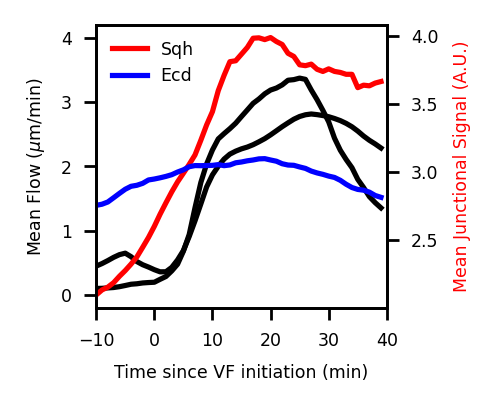

In [46]:
plt.rcParams['font.size'] = 5

loaddir = 'Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'cyt2D.npy'), mmap_mode='r')
cad_vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')

loaddir = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
DV = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
AP = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')

dv = DV[:, 0]
ap = AP[0, :]

nDV = dv.shape[0]
nAP = ap.shape[0]
nTP = t.shape[0]
    
sqh = sqh * 3e1
cad = cad * 1.5e0
    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax.plot(t, np.linalg.norm(cad_vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 40])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

from scipy.ndimage import gaussian_filter
from atlas_processing.anisotropy_detection import cell_size
cad = np.stack([
    gaussian_filter(cad[i], sigma=cell_size) for i in range(cad.shape[0])])
print('Data shapes')
print('Sqh: ', sqh.shape)
print('Cad: ', cad.shape)
print('Vel: ', vel.shape)

In [117]:
def radial_average(arr, num_bins=100):
    arr = arr.reshape([nDV, nAP])
    center = (nDV // 2, nAP // 2)

    x, y = np.meshgrid(np.arange(nAP), np.arange(nDV))
    distances = np.hypot(x - center[1], y - center[0])

    sorted_distances = np.sort(distances.ravel())
    sorted_values = arr.ravel()[np.argsort(distances.ravel())]

    bins = np.linspace(0, (nAP/(2 * np.sqrt(2))), num_bins + 1)
    bins = np.linspace(0, sorted_distances.max(), num_bins+1)
    bin_indices = np.digitize(sorted_distances, bins)

    radial_avg = np.bincount(bin_indices, weights=sorted_values) / np.bincount(bin_indices)
    
    trunc = bins < nAP / (2 * 1.414)
    return radial_avg[1:][trunc]

    return radial_avg[1:]

qAP = np.fft.fftshift(np.fft.fftfreq(nAP, d=ap[1]-ap[0]))
qDV = np.fft.fftshift(np.fft.fftfreq(nDV, d=dv[1]-dv[0]))
q = np.linalg.norm(np.meshgrid(qAP, qDV), axis=0)

q = radial_average(q)

Text(0, 0.5, '$|m(\\mathbf{q})|^2$')

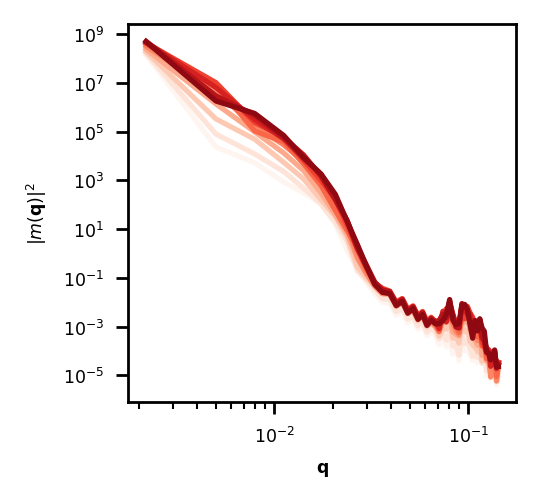

In [127]:
from scipy.signal import blackman, hann

window_AP = hann(nAP)
window_DV = hann(nDV)
window = window_AP[None, :] * window_DV[:, None]

sqh_q = np.abs(np.fft.fft2(sqh * window))**2
trm_q = np.einsum('tjjyx->tyx', sqh_q)
sqh_q = np.fft.ifftshift(sqh_q, axes=(-2, -1))
sqh_qt = np.apply_along_axis(radial_average, 1, np.einsum('tjjyx->tyx', sqh_q).reshape([nTP, -1]))
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, sqh_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{q}$')
ax.set_ylabel(r'$|m(\mathbf{q})|^2$')

Text(0, 0.5, '$|c(\\mathbf{q})|^2$')

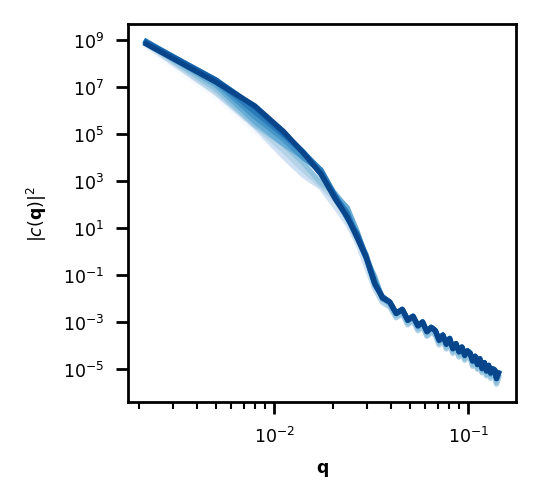

In [129]:
cad_q = np.abs(np.fft.fft2(cad * window))**2
cad_q = np.fft.ifftshift(cad_q, axes=(-2, -1))
cad_qt = np.apply_along_axis(radial_average, 1, cad_q.reshape([nTP, -1]))

cmap = plt.cm.Blues
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, cad_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{q}$')
ax.set_ylabel(r'$|c(\mathbf{q})|^2$')

Text(0, 0.5, '$|v(\\mathbf{q})|^2$')

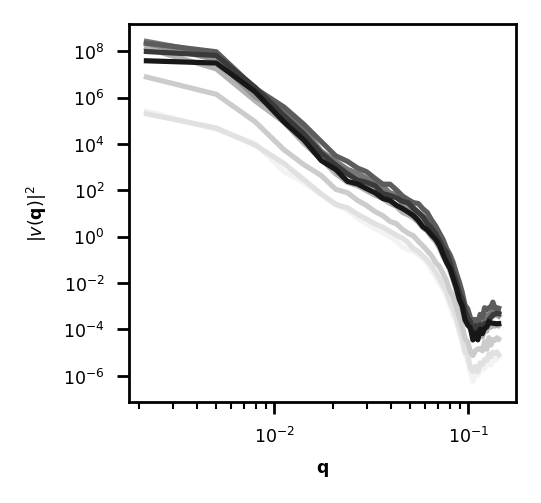

In [131]:
vel_q = np.abs(np.fft.fft2(vel * window))**2
vel_q = np.fft.ifftshift(vel_q, axes=(-2, -1))
vel_qt = np.apply_along_axis(radial_average, 1, np.linalg.norm(vel_q, axis=1).reshape([nTP, -1]))

cmap = plt.cm.Greys
norm = plt.Normalize(vmin=t.min(), vmax=t.max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=250)
for tt in range(0, len(t), 5):
    ax.plot(q, vel_qt[tt], c=cmap.to_rgba(t[tt]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{q}$')
ax.set_ylabel(r'$|v(\mathbf{q})|^2$')